In [4]:
import pandas as pd
import numpy as np
import itertools
import random
import ast
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits import mplot3d
from scipy.spatial import distance
from pyxdameraulevenshtein import damerau_levenshtein_distance

pd.set_option('display.max_rows', 500)

In [5]:
df = pd.read_csv('all_task_environments.csv', header=0, skiprows=[1])

In [6]:
objects = ['t', 'n', 's', 'p', 'c']

coordinates = {'c': (1,4,4),
              'n': (1,1,2),
              'p': (1,4,4),
              's': (1,2,2),
              't': (1,1,2),
              'start': (2,1,2),
              'table': (4,3,2)}

c1 = {'c': 1.2,
    'n': 1.0,
    'p': 1.2,
    's': 1.2,
    't': 1.0}

k1 = {'c': 1.0,
    'n': 0.95,
    'p': 0.95,
    's': 1.0,
    't': 0.9}

start_coordinates = [[2,1.5,2],[4,3,2],[4,3,2],[4,3,2],[4,3,2]]

In [7]:
def predict_sequence(objects, coordinates, start_coordinates, c, k, dimension=[3,], steps=1):
    prediction = []
    possible_items = dict.fromkeys(objects, 0) # generate dict from object list
    coord_index = 0
    start_coords = start_coordinates
    coords = coordinates
    new_coords = {}
    new_start_coords = []
    
    if dimension[0] == 3: # no changes if 3D
        new_coords = coords
        new_start_coords = start_coords
        
    elif dimension[0] == 2: # 2D: remove obsolete coordinate
        if dimension[1] == 'xy':
            new_coords = {key: value[:-1] for key, value in coords.items()}
            new_start_coords = [x[:-1] for x in start_coords]
                
        elif dimension[1] == 'xz':
            new_start_coords = [[x[0], x[-1]] for x in start_coords]
            
            for key, value in coords.items():
                new_value = (value[0], value[-1])
                new_coords[key] = new_value
        
        elif dimension[1] == 'yz':
            new_coords = {key: value[1:] for key, value in coords.items()}
            new_start_coords = [x[1:] for x in start_coords]
                
    elif dimension[0] == 1: # 1D: choose appropriate coordinate
        if dimension[1] == 'x':
            new_coords = {key: value[0] for key, value in coords.items()}
            new_start_coords = [x[0] for x in start_coords]
        
        elif dimension[1] == 'y':
            new_coords = {key: value[1] for key, value in coords.items()}
            new_start_coords = [x[1] for x in start_coords]
        
        elif dimension[1] == 'z':
            new_coords = {key: value[2] for key, value in coords.items()}
            new_start_coords = [x[2] for x in start_coords]
    
    while bool(possible_items) == True: # while dict not empty
        for obj in possible_items.keys():
            possible_items[obj] = ((distance.euclidean(
                                new_start_coords[coord_index], 
                                new_coords[obj])
                                ) ** k[obj]) * c[obj]
        
        #print(possible_items)                      
        minval = min(possible_items.values())
        minval = [k for k, v in possible_items.items() if v == minval]
        minval = random.choice(minval) # choose prediction randomly if multiple items have same cost
        #print(minval)
        del possible_items[minval]
        
        if steps == 2 and bool(possible_items) == True:
            for obj in possible_items.keys():
                possible_items[obj] = ((distance.euclidean(
                                    new_coords[minval],
                                    new_coords[obj])
                                    )
                                    ** k[obj]) * c[obj]
            #print(possible_items)
            minval_step2 = min(possible_items.values())
            minval_step2 = [k for k, v in possible_items.items() if v == minval_step2]
            minval_step2 = random.choice(minval_step2) # choose prediction randomly if multiple items have same cost
            #print(minval_step2 + '____')
            del possible_items[minval_step2]
            prediction.append(''.join([minval, minval_step2]))
            coord_index += 1
            
        else:
            prediction.append(minval)
          
        coord_index += 1
        
    return prediction

In [8]:
predict_sequence(objects, coordinates, start_coordinates, c1, k1, steps=2)

['tn', 'sp', 'c']

In [9]:
def get_average(objects, coordinates, start_coordinates, c, k, dimension, sequence, steps=1):

    edit_list = []

    for x in range(0,100):
        result = ''.join(predict_sequence(objects, coordinates, start_coordinates, c, k, dimension))
        dl = damerau_levenshtein_distance(sequence,result)
        edit_list.append(dl)
    
    avg = np.mean(edit_list)
    return avg

In [10]:
def get_avg_editdist(data, steps=1):
    results = pd.DataFrame()
    dimensions = [[1,'x'],[1,'y'],[1,'z'],[2,'xy'],[2,'xz'],[2,'yz'],[3,'xyz']]
        
    for row in range(0,len(df)):
        objects = list(df.at[row,'objects'].split(','))
        strong_k = list(df.at[row,'strong_k'].split(','))
        mid_k = list(df.at[row,'mid_k'].split(','))
        coordinates = {key: ast.literal_eval(value) for key, value in (elem.split(': ') for elem in df.at[row,'coordinates'].split(';'))}
        start_coordinates = list(ast.literal_eval(df.at[row, 'start_coordinates']))
        sequence = str(df.at[row,'sequence'])
        
        #for k in np.arange(0.0,1.0,0.1):
        for k in np.arange(0,0.9,0.1):
            k_strong = round(k,2)
            k_mid = round(k + 0.1,2)
            k1 = {obj: k_strong if obj in strong_k else k_mid if obj in mid_k else 1.0 for obj in objects}
                    
            for c in np.arange(1.0,2.0,0.1):
                c = round(c, 1)
                c1 = {obj: c if obj in df.at[row, 'containment'] else 1.0 for obj in objects}
                
                for dim in dimensions:                
                    # get average edit distance
                    edit_dist = get_average(objects, coordinates, start_coordinates, c1, k1, dim, sequence)
                    edit_dist = edit_dist / len(sequence)
                    
                    #params = 'c: ' + str(c) + ', k: ' + str(k_strong) + ',' + str(k_mid) + ', dim: ' + str(dim[1])
                    params = 'c: ' + str(c) + '; k: ' + str(k_strong) + ',' + str(k_mid) + '; ' + str(dim[1])
                    results.at[row,params] = edit_dist
                    
    return results

#TODO:
# range for diff between strong/mid k?
# range for c and k in general?

In [11]:
#%%timeit -n1 -r1
results_new = get_avg_editdist(df, steps=2)

In [12]:
results_new

,"c: 1.0; k: 0.0,0.1; x","c: 1.0; k: 0.0,0.1; y","c: 1.0; k: 0.0,0.1; z","c: 1.0; k: 0.0,0.1; xy","c: 1.0; k: 0.0,0.1; xz","c: 1.0; k: 0.0,0.1; yz","c: 1.0; k: 0.0,0.1; xyz","c: 1.1; k: 0.0,0.1; x","c: 1.1; k: 0.0,0.1; y","c: 1.1; k: 0.0,0.1; z",...,"c: 1.8; k: 0.8,0.9; xz","c: 1.8; k: 0.8,0.9; yz","c: 1.8; k: 0.8,0.9; xyz","c: 1.9; k: 0.8,0.9; x","c: 1.9; k: 0.8,0.9; y","c: 1.9; k: 0.8,0.9; z","c: 1.9; k: 0.8,0.9; xy","c: 1.9; k: 0.8,0.9; xz","c: 1.9; k: 0.8,0.9; yz","c: 1.9; k: 0.8,0.9; xyz"
0,0.414000,0.858000,0.702000,0.304000,0.200000,0.400000,0.000000,0.202000,0.600000,0.690000,...,0.304000,0.400000,0.200000,0.206000,0.438000,0.458000,0.092000,0.304000,0.400000,0.200000
1,0.402000,0.600000,0.678000,0.200000,0.338000,0.600000,0.200000,0.210000,0.600000,0.708000,...,0.516000,0.600000,0.400000,0.202000,0.600000,0.554000,0.400000,0.504000,0.600000,0.400000
2,0.380000,0.600000,0.698000,0.000000,0.204000,0.600000,0.000000,0.180000,0.600000,0.704000,...,0.296000,0.400000,0.200000,0.206000,0.400000,0.464000,0.200000,0.294000,0.400000,0.200000
3,0.566000,0.400000,0.400000,0.200000,0.324000,0.400000,0.200000,0.420000,0.400000,0.400000,...,0.102000,0.200000,0.000000,0.386000,0.200000,0.264000,0.000000,0.106000,0.200000,0.000000
4,0.336667,0.666667,0.666667,0.486667,0.333333,0.666667,0.333333,0.000000,0.666667,0.333333,...,0.000000,0.503333,0.333333,0.000000,0.480000,0.180000,0.486667,0.000000,0.476667,0.333333
5,0.696000,0.470000,0.800000,0.620000,0.400000,0.306000,0.400000,0.716000,0.302000,0.800000,...,0.400000,0.800000,0.800000,0.646000,0.400000,0.800000,0.640000,0.400000,0.800000,0.800000
6,0.812500,0.697500,0.820000,1.000000,0.720000,1.000000,1.000000,0.755000,0.705000,0.760000,...,0.775000,0.500000,0.500000,0.715000,0.500000,0.760000,0.500000,0.755000,0.500000,0.500000
7,0.750000,1.000000,0.702500,1.000000,0.735000,1.000000,1.000000,1.000000,1.000000,0.692500,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.690000,1.000000,1.000000,1.000000,1.000000
8,0.166667,0.333333,0.413333,0.000000,0.166667,0.306667,0.000000,0.163333,0.353333,0.436667,...,0.176667,0.380000,0.000000,0.156667,0.313333,0.456667,0.000000,0.153333,0.306667,0.000000
9,0.170000,0.513333,0.193333,0.333333,0.173333,0.333333,0.333333,0.166667,0.533333,0.190000,...,0.180000,0.333333,0.333333,0.156667,0.496667,0.170000,0.333333,0.166667,0.333333,0.333333


In [14]:
def get_lowest_error(results):
    for col in list(results):
        results.loc['mean',col] = results[col].mean()
    lowest = min(results.loc['mean'])
    mean = sorted(results.loc['mean'])
    
    return lowest, results.columns[(results.loc['mean'] == lowest)], mean, results

In [15]:
lowest, lowest_idx, list_mean, results_mean = get_lowest_error(results_new)
lowest, lowest_idx

(0.4126094576719576, Index(['c: 1.5; k: 0.4,0.5; xy'], dtype='object'))

In [16]:
c = [float(x[3:6]) for x in results_new.columns.tolist()]
k = [float(x[11:14]) for x in results_new.columns.tolist()]
dim = [x.strip() for x in results_new.columns.str.split(';').str[2]]
error = results_mean.loc['mean'].tolist()


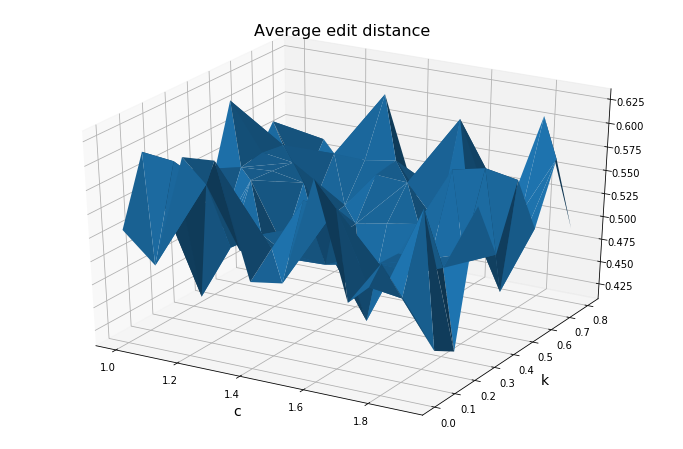

In [17]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')

ax.plot_trisurf(c, k, error, linewidth=0.2)
ax.set_ylabel('k', fontsize=14, labelpad=7)
ax.set_xlabel('c', fontsize=14, labelpad=7)
plt.title('Average edit distance', fontsize=16)
plt.show()

In [20]:
%matplotlib qt

cm = ['red','blue','green','magenta','cyan','orange','grey']
dim_num = [0 if x=='x' else 1 if x=='y' else 2 if x=='z' else 3 if x=='xy' else 4 if x=='xz' else 5 if x=='yz' else 6 for x in dim]

cmap = matplotlib.colors.ListedColormap(cm)

ticks = ['x', 'y', 'z', 'xy', 'xz', 'yz', 'xyz']
norm = matplotlib.colors.BoundaryNorm(ticks, cmap.N)

# create figure, 3d grid, set background to white
fig2 = plt.figure(figsize=(12,8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.w_xaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax2.w_yaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax2.w_zaxis.set_pane_color((1.0,1.0,1.0,1.0))

# create plot
img = ax2.scatter(c, k, error, alpha=0.5, s=38, c=dim_num, cmap=cmap)

# set labels
ax2.set_ylabel('parameter k', fontsize=14, labelpad=7)
ax2.set_xlabel('parameter c', fontsize=14, labelpad=7)
ax2.set_zlabel('normalized edit distance', fontsize=14, labelpad=7)
plt.title('Average edit distance 2-steps', fontsize=16)

# create colorbar
cb = plt.colorbar(img, cax = fig2.add_axes([0.9,0.3,0.03,0.4]))
cb.ax.set_yticklabels(ticks)
plt.show()

In [281]:
# generate rotating image

fig3 = plt.figure(figsize=(12,8))
ax3 = mplot3d.Axes3D(fig3)
ax3.w_xaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.w_yaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.w_zaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.set_ylabel('parameter k', fontsize=14, labelpad=7)
ax3.set_xlabel('parameter c', fontsize=14, labelpad=7)
ax3.set_zlabel('normalized edit distance', fontsize=14, labelpad=7)

def init():
    ax3.scatter(c, k, error, alpha=0.5, s=38, c=dim_num, cmap=cmap)
    
    return fig,

def animate(i):
    ax3.view_init(elev=10, azim=i*4)
    return fig,

animated = animation.FuncAnimation(fig3, animate, init_func=init, frames=90, interval=50, blit=True)

In [284]:
# save animated fig

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

fig_name = 'rotate_model_lowesterror_3D'
#animated.save(fig_name+'.gif', writer='imagemagick', fps=1000/50)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, bitrate=10000)
animated.save(fig_name+'.mp4', writer=writer)